In [1]:
import numpy as np
import matplotlib.pylab as plt
import torch, requests
from io import BytesIO
from PIL import Image
from torchvision import transforms as TF
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from utils.diffseg_pytorch import run_diffseg

In [2]:
device = torch.device("cuda:0")
dtype = torch.float16

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=dtype)
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
image_transform = TF.Compose([
    TF.Resize((768, 768)),
    TF.ToTensor(),
    TF.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
@torch.inference_mode()
def encode_images(pipe, images):
    z = pipe.vae.encode(images).latent_dist.mode()
    z = z * pipe.vae.config.scaling_factor
    return z


@torch.inference_mode()
def decode_images(pipe, z):
    z = z / pipe.vae.config.scaling_factor
    image = pipe.vae.decode(z).sample
    image = image.clamp(-1, 1)
    return image


@torch.inference_mode()
def encode_prompt(pipe, prompts):
    text_inputs = pipe.tokenizer(
        prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    input_ids = text_inputs.input_ids.to(pipe.device)
    prompt_embeds = pipe.text_encoder(input_ids, attention_mask=None)
    return prompt_embeds[0]

In [5]:
def load_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image_transform(image)
    return image

In [6]:
def run_diffseg_exp(image_url):
    image = load_image(image_url)
    image = image[None].to(device, dtype)
    
    latents = encode_images(pipe, image)
    prompt_embeds = encode_prompt(pipe, [""])
    segmentation_proposals = run_diffseg(
        latents=latents, 
        pipe=pipe, 
        t=100, 
        prompt_embeds=prompt_embeds,
        anchor_grid_size=(16, 16),
        target_size=(768, 768),
        tau=0.8,
        n_iters=5
    )

    image_vis = image[0].permute(1, 2, 0).float().cpu().numpy()*0.5 + 0.5
    segmentation_proposals_vis = segmentation_proposals[0].float().cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.imshow(image_vis)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_proposals_vis)
    plt.axis("off")

    plt.show()


Initial num of proposals: 256
Num of proposals (iter 2): 14
Num of proposals (iter 3): 8
Num of proposals (iter 4): 7
Num of proposals (iter 5): 7


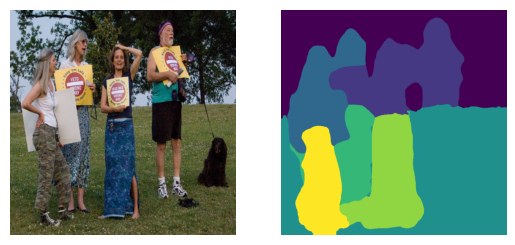

In [7]:
image_url = "https://c3.staticflickr.com/1/168/483547040_ecd0282be3_o.jpg"
run_diffseg_exp(image_url)

Initial num of proposals: 256
Num of proposals (iter 2): 9
Num of proposals (iter 3): 5
Num of proposals (iter 4): 5


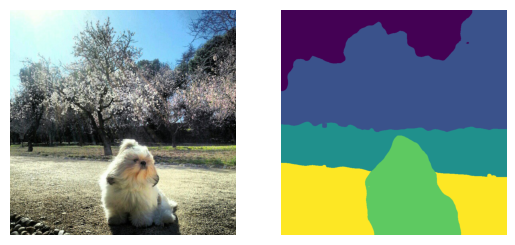

In [8]:
image_url = "https://farm4.staticflickr.com/8093/8500931688_d093e69b45_o.jpg"
run_diffseg_exp(image_url)

Initial num of proposals: 256
Num of proposals (iter 2): 16
Num of proposals (iter 3): 10
Num of proposals (iter 4): 9
Num of proposals (iter 5): 9


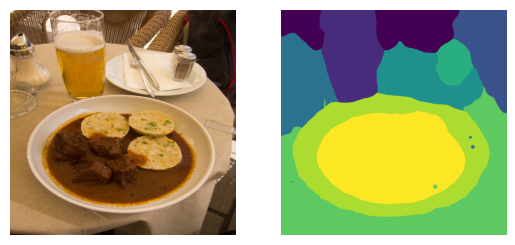

In [9]:
image_url = "https://farm3.staticflickr.com/7375/14124836862_c7282ebf1a_o.jpg"
run_diffseg_exp(image_url)